# Binary Classification using CNN and pre trained model comparison

Is that a sloth or a pain au chocolat? is the online question that never gets old. I will be attempting to complete this binary image classification challenge using my recently acquired deep learning abilities!

![sloth_or_pain_au_chocolat.jpg](864923.jpg)

Neural network creation and training from scratch is rare among data scientists and machine learning engineers in the era of deep learning. Nonetheless, gathering, preparing, and loading data to feed into a model comprises a significant portion of the work involved in completing a machine learning activity. Although I will tweak the model a little, this will not be the main emphasis of the training.

In this session, I'll be adapting code from PyTorch.org's [tutorials](https://pytorch.org/tutorials) on [loading custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to load a dataset we have collected into PyTorch. Special thanks to DataCamp.

Then I'll then use [this tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning) to perform an image processing task using a mostly-pretrained model, which I would also try to fine tune.

Specifically, the labeling of the images would be with one of two labels: `sloth`, or `pain_au_chocolat`.

# importing libraries

In [25]:
import matplotlib.pyplot as plt
import copy, os
import numpy as np
import time

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchmetrics import Precision, Recall

In [26]:
# Enable cudnn benchmark
cudnn.benchmark = True

In [27]:
# Change selected device to CUDA, a parallel processing platform, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(device.type)

cuda:0
cuda


# using scratch made CNN

## data loading & augmentation

In [28]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

dataset_train = ImageFolder('data/sloths_versus_pain_au_chocolat/train', transform=train_transforms)
data_loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)

In [29]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

dataset_test = ImageFolder('data/sloths_versus_pain_au_chocolat/val', transform=test_transforms)
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=True)

In [30]:
class_names = dataset_train.classes
print(class_names)

['pain_au_chocolat', 'sloths']


## model building from scratch

In [31]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32x256x256
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2), # 32x128x128
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x128x128
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2), # 64x64x64
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1), # 32x64x64
            nn.BatchNorm2d(32),
            nn.ELU(),
            # nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2), # 32x32x32
            
            # nn.Conv2d(32, 16, kernel_size=3, padding=1, stride=2), # 16x16x16
            # nn.BatchNorm2d(16),
            # nn.ELU(),
            # # nn.Dropout(p=0.2),
            # nn.MaxPool2d(kernel_size=2), # 16x8x8
            
            nn.Flatten(),
            
            # nn.Dropout(p=0.2),
            # nn.Linear(16*8*8, 1024),
            # nn.BatchNorm1d(1024),
            # nn.ReLU(),
            
            # nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),
            # nn.ReLU(),
            # nn.Linear(512, 10)
        )
        self.classifier = nn.Linear(32*32*32, num_classes)
        
        # Apply Kaiming Uniform initialization to all layers
        # self._initialize_weights()
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        # Iterate through all modules and initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Kaiming uniform for Conv layers
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Kaiming uniform for Linear layers
                nn.init.zeros_(m.bias)

## training loop

In [32]:
def calculate_accuracy_train(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    
    return correct / labels.size(0)

In [33]:
net = Net(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.000006, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

n_epoch = 1002

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_acc = 0.0
best_epoch = 0
best_precision = 0
best_recall = 0

for epoch in range(n_epoch):
    print(f'Epoch {epoch}/{n_epoch-1}')
    print('-' * 10)
    
    # training phase
    net.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in data_loader_train:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        # calculate loss and acc for training set
        running_loss += loss.item() * images.size(0)
        running_corrects += calculate_accuracy_train(outputs, labels) * images.size(0)
    
    train_epoch_loss = running_loss / len(dataset_train)
    train_epoch_acc = running_corrects / len(dataset_train)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    
    print(f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}')
    
    # Validation phase
    net.eval()  
    test_running_loss = 0.0
    test_running_corrects = 0

    metric_precision = Precision(task='binary', num_classes=2, average='macro').to(device)
    metric_recall = Recall(task='binary', num_classes=2, average='macro').to(device)

    with torch.no_grad():
        for images, labels in data_loader_test:
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            
            metric_precision.update(predicted, labels)
            metric_recall.update(predicted, labels)

            # Calculate loss and accuracy for the validation set
            test_running_loss += loss.item() * images.size(0)
            test_running_corrects += (correct / labels.size(0)) * images.size(0)
        
    test_epoch_precision = metric_precision.compute()
    test_epoch_recall = metric_recall.compute()

    test_epoch_loss = test_running_loss / len(dataset_test)
    test_epoch_acc = test_running_corrects / len(dataset_test)

    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    
    print(f'Validation Loss: {test_epoch_loss:.4f}, Validation Acc: {test_epoch_acc:.4f}')
    print(f'precision: {test_epoch_precision:.4f}, recall: {test_epoch_recall:.4f}')
    print()
    
    if test_epoch_acc > best_acc:
        best_acc = test_epoch_acc
        best_epoch = epoch
        best_precision = test_epoch_precision
        best_recall = test_epoch_recall
        best_model_wts = copy.deepcopy(net.state_dict())
    
# print(best_epoch, best_acc)
print(f'best acc: {best_acc:.4f} at epoch: {best_epoch}, precision: {best_precision:.4f}, recall: {best_recall:.4f}')
    

Epoch 0/99
----------
Train Loss: 0.5856, Train Acc: 0.6946
Validation Loss: 0.5591, Validation Acc: 0.6818
precision: 0.9091, recall: 0.4348

Epoch 1/99
----------
Train Loss: 0.4696, Train Acc: 0.7964
Validation Loss: 0.4219, Validation Acc: 0.8409
precision: 0.9444, recall: 0.7391

Epoch 2/99
----------
Train Loss: 0.3398, Train Acc: 0.8683
Validation Loss: 0.3446, Validation Acc: 0.8409
precision: 0.9444, recall: 0.7391

Epoch 3/99
----------
Train Loss: 0.3290, Train Acc: 0.8683
Validation Loss: 0.3202, Validation Acc: 0.9091
precision: 0.9130, recall: 0.9130

Epoch 4/99
----------
Train Loss: 0.3246, Train Acc: 0.8623
Validation Loss: 0.3046, Validation Acc: 0.9318
precision: 0.9545, recall: 0.9130

Epoch 5/99
----------
Train Loss: 0.2816, Train Acc: 0.8982
Validation Loss: 0.2804, Validation Acc: 0.9545
precision: 0.9565, recall: 0.9565

Epoch 6/99
----------
Train Loss: 0.2086, Train Acc: 0.9401
Validation Loss: 0.2741, Validation Acc: 0.9318
precision: 0.9167, recall: 0.9565


## visualizing loss acc curve

In [34]:
def loss_acc_curve(train_losses, test_losses, train_accuracies, test_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

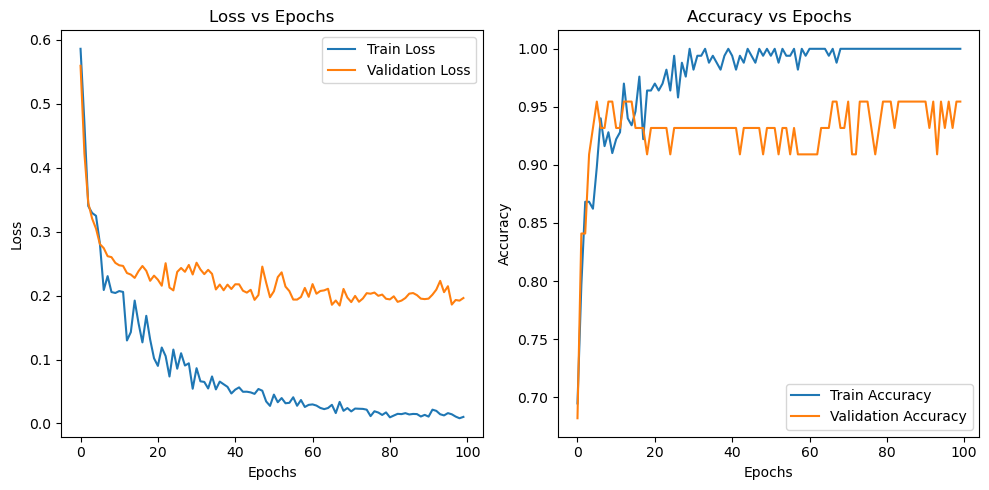

In [35]:
loss_acc_curve(train_losses, test_losses, train_accuracies, test_accuracies)

In [36]:
# lr=0.000008, weight_decay=1e-4 -> best acc: 0.9545 at epoch: 21, precision: 0.9200, recall: 1.0000

# try model change drop out batchnormal
# lr=0.000008, weight_decay=1e-4,  2nd drop out .5 tp .1 -> best acc: 0.9773 at epoch: 22, precision: 0.9583, recall: 1.0000

# trying same with no 2nd drop out -> best acc: 0.9318 at epoch: 40, precision: 0.8846, recall: 1.0000
# valo kore nai 

# using pretrained model

## data loading & augmentation

additonal transfoms: Using tensors as input, use the `transforms.normalize()` function to normalize a tensor image using the supplied means and standard deviations, supplied as lists as the first and second parameters, respectively. We can utilize the ImageNet dataset's mean and standard deviation if the images are comparable to ImageNet images. These are the following:
- `mean` = [0.485, 0.456, 0.406] 
- `std` = [0.229, 0.224, 0.225]

In [37]:
# Create data transforms
data_transforms = {
    'train' : transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    ),
    'val' : transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    )
}

In [38]:
# Provide data directory
data_dir = 'data/sloths_versus_pain_au_chocolat'

# Create image folders for our training and validation data 
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]
                                         )
                 for x in ['train', 'val']}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Obtain class_names from image_datasets
class_names = image_datasets['train'].classes
print(class_names)

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size = 4,          
                                              shuffle=True)
               for x in ['train', 'val']}

['pain_au_chocolat', 'sloths']


## visulizing data

In [39]:
def imshow(inp, title=None):
    """
    This function will make use of Matplotlib.pyplot's imshow() function for tensors. 
    It will show the same number of images as the batch we defined.
    """
    # A transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0)) 

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    
    # To visualize the correct colors     
    inp = std * inp + mean
    
    # To view a clipped version of an image             
    inp = np.clip(inp, 0, 1)
    
    # Visualize inp
    plt.imshow(inp)
    
    if title is not None: # Plot title goes here
        plt.title(title)
    plt.pause(0.001)  # Enables the function to pause while the plots are updated


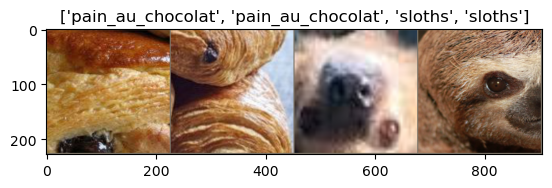

In [40]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

## defining training and visualizing functions

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''
    
    since = time.time()

    # Make a deep copy of the model provided     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [42]:
def visualize_model(model, num_images=6):
    '''
    Function that will visualize results of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## loading pre trained model

In [43]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [44]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.3227 Acc: 0.8503
val Loss: 0.0127 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.4736 Acc: 0.7964
val Loss: 0.0512 Acc: 0.9545

Epoch 2/24
----------
train Loss: 0.4001 Acc: 0.8802
val Loss: 0.1413 Acc: 0.9318

Epoch 3/24
----------
train Loss: 0.3275 Acc: 0.8503
val Loss: 0.0472 Acc: 0.9773

Epoch 4/24
----------
train Loss: 0.3268 Acc: 0.8862
val Loss: 0.0255 Acc: 0.9773

Epoch 5/24
----------
train Loss: 0.2904 Acc: 0.9042
val Loss: 0.0244 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.4541 Acc: 0.8263
val Loss: 0.0128 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2063 Acc: 0.9162
val Loss: 0.0119 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1747 Acc: 0.9401
val Loss: 0.0093 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1338 Acc: 0.9641
val Loss: 0.0111 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2193 Acc: 0.9341
val Loss: 0.0111 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1146 Acc: 0.9581
val Loss: 0.0122 Acc: 1.0000

Ep

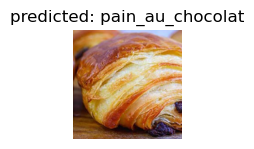

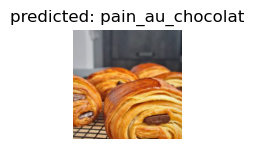

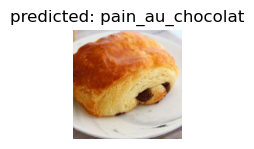

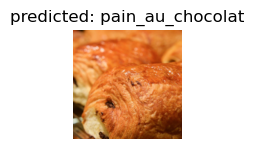

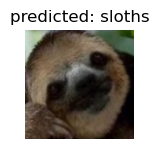

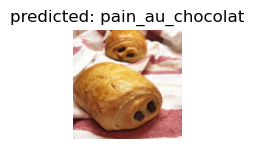

In [45]:
visualize_model(model_ft)

In [46]:
# Disable gradients for model_conv.parameters()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_conv = model_conv.to(device)

# Set criterion again
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [47]:
# Train model_conv
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25) #ekhane

Epoch 0/24
----------
train Loss: 0.4995 Acc: 0.7665
val Loss: 0.0378 Acc: 0.9773

Epoch 1/24
----------
train Loss: 0.4581 Acc: 0.8144


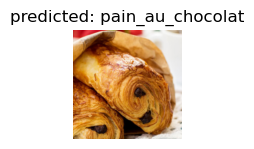

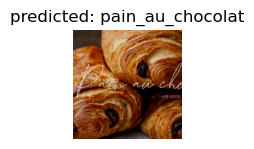

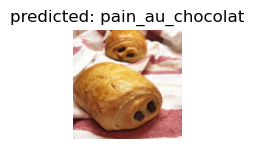

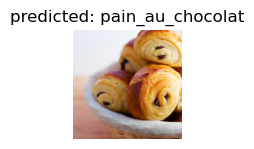

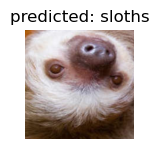

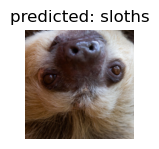

In [24]:
# Visualize model
visualize_model(model_conv)
plt.show()

# Conclusion

My scratch built CNN achieved 95% accuracy whereas resnet18 outperformed with accuracy of 100%. When disabled the gradients for convulation layers, it learned much faster. 

The loss acc curve of my neural network feels good, with more tweaking the parameters i can smoothen them and that can be visualized with more epochs i believe!